In [1]:
### Cell to read in the data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm


sources_folder = "../data/"

data_sources = [
    ("R1B9_RvsT_5mV_New.xlsx", "Ithaca_all"),
    ("R2B8_RvsT_5mV_New.xlsx", "Ithaca_9+10"),
    ("R1B9_RvsT_200mV.xlsx", "Ithaca_all"),
    ("R2B8_RvsT_200mV.xlsx", "Ithaca_all"),
]

data_map = {}

for file, sheet_name in tqdm(data_sources):
    df = pd.read_excel(sources_folder + file, sheet_name=sheet_name)
    # filter out negative currents for fitting purposes
    df = df[df.Current != "--"]
    df = df[df.Current > 0]

    df = df[df.Voltage != "--"]
    df = df[df.Temp != "--"]
    df["Conductance"] = df["Current"] / df["Voltage"]

    data_map[file + ":" + sheet_name] = df


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


In [3]:
### Define functions

k_b = 1.380649e-23 #m^2 kg/s^2/K
def IV_fit(x, a, b, c, d, f):
    '''
    Simple linear regression
    :param x: inputs
    :param a-f: prefactors
    :return: value of the fit at x
    '''
    return a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + f

def plot_IV_curve_simple(file, sheet_name, axs=None, silent=False
                         , voltage_lower_bound = None, voltage_upper_bound=None):
    """
    :param file: Name of the file to read from
    :param sheet_name: Name of the sheet in the file
    :param axs: Optional argument with axs to plot on
    """
    df = pd.read_excel(file, sheet_name=sheet_name)
    df = df.query("Voltage > 0")
    if voltage_upper_bound != None:
        df = df.query("Voltage < {}".format(voltage_upper_bound))
    if voltage_lower_bound != None:
        df = df.query("Voltage > {}".format(voltage_lower_bound))
    if silent:
        return df['Voltage'], df['Current']

    if axs == None:
        axs = plt.axes()

    axs.plot(df['Voltage'], df['Current'])
    axs.set_xlabel("Voltage")
    axs.set_ylabel("Current")
    axs.set_title("Voltage-Current curve for {}".format(sheet_name))
    return df['Vsd'], df['Current']


def deriv(xs, ys):
    '''
    Compute the "derivative" of a function (xs, ys)
    :param xs: xs
    :param ys: ys
    :return: list of derivatives at xs
    '''
    outs = []
    xs = list(xs)
    ys = list(ys)
    for i in range(0,len(xs)-1):
        outs.append((ys[i+1]-ys[i])/(xs[i+1]-xs[i]+1e-100))
    return outs

### Temperature and Conductance ###
def conductance_to_temp_fit(x,  b, c, d):
    '''Function used for predicting temperature from conductance'''
    return  b * np.power(x, c) * np.exp(d * x)

def fit_cond_to_temp(conductance, temp, offset):
    '''Function that fits a function to predict temp from conductance
    :returns: function, coefficients
    '''
    conds = np.array(conductance) + offset * 1000 / 5
    temp = list(temp)

    # filter positive conductances
    temp_out, cond_out = [], []
    for i in range(len(conds)):
        if conds[i] > 0:
            temp_out.append(temp[i])
            cond_out.append(conds[i])


    coeffs, cov = curve_fit(conductance_to_temp_fit, np.array(cond_out),
                            np.array(temp_out)
                            , bounds=(( 0, -np.inf, 0)
                                      , ( np.inf, np.inf, np.inf))
                            , p0=[ 2.3e+03, 0, 1e+06]
    )
    # default args used to store values and make a closure
    cond_to_temp = lambda x, offset=offset, coeff=coeffs: conductance_to_temp_fit(x+offset * 1000 / 5, *coeff)
    return cond_to_temp, coeffs


# do a binary search, assume f is monotonically increasing
def get_conductance(target_t, f, threshold=0.0001):
    '''
    Determine the conductance for a given temperature from a give function
    :param target_t: temperature to look at
    :param f: function to look at
    :param threshold: threshold of error
    :return: the conductance
    '''
    mini = -1
    maxi = 1
    while f(maxi) < target_t:
        maxi *= 2
    while f(mini) > target_t:
        mini *= 2
    center = (mini + maxi) / 2
    while abs(target_t - f(center)) > threshold:
        if f(center) < target_t:
            mini = center
        else:
            maxi = center
        center = (mini + maxi) / 2
    return center


def optimize_current_offset(target_conductance, key, offset=0, threshold=1e-16, adjustment = 1e-10):
    ''' Determine how much we need to offset our raw data to make the conductance include the suggested point'''
    first = True
    last_offset = 1
    last_diff = 0
    diff = 1
    df = data_map[key].copy()
    df["Current"] += offset
    df["Conductance"] = df["Current"] / df["Voltage"]
    df = df.query("Conductance > 0")
    while first or abs(offset - last_offset) > threshold:
        adjustment *= 0.95
        first = False

        df = data_map[key].copy()
        df["Current"] += offset
        df["Conductance"] = df["Current"] / df["Voltage"]
        df = df.query("Conductance > 0")
        temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, coeffs = fit_cond_to_temp(conductance, temp, -offset)


        estimated_temp = cond_to_temp(target_conductance)



        last_diff = diff
        diff = simulation_temperature - estimated_temp

        last_offset = offset

        if diff > 0:
            offset -= adjustment
        else:
            offset += adjustment

        if last_diff * diff < 0:
            adjustment = min(abs(last_offset - offset) / 2, adjustment / 2)
            if abs(offset - last_offset) < 0 * threshold:
                break


    return offset, cond_to_temp


# gradient descent until we oscillate between positive and negative then binary search
# with the oscillating values
def optimize_voltage_offset(target_conductance, key, adjustment=3 / 10000, threshold=1e-6):
    first = True
    diff = 1

    # first gradient descent to get near the correct voltage
    offset = 0
    last_diff = 0
    last_offset = 1
    while first or abs(offset - last_offset) > threshold:
        if last_diff * diff < 0:
            adjustment *= .5
        adjustment *= .95
        first = False
        df = data_map[key].copy()
        df["Voltage"] += offset
        df["Conductance"] = df["Current"] / df["Voltage"]
        temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, _ = fit_cond_to_temp(conductance, temp,0)
        estimated_temp = cond_to_temp(target_conductance)
        last_diff = diff
        diff = simulation_temperature - estimated_temp

        last_offset = offset
        if diff > 0:
            offset += adjustment
        else:
            offset -= adjustment
        print("Distance: ", diff, "Offset: ", offset)
    print("Offset found!!!")

    mini = min(offset, last_offset)  # (setup bounds we just found to binary search)
    maxi = max(offset, last_offset)
    center = (mini + maxi) / 2

    while first or abs(mini - maxi) > threshold:
        first = False
        df = data_map[key].copy()
        df["Voltage"] += center
        df["Conductance"] = df["Current"] / df["Voltage"]
        temp, current, voltage, conductance \
            = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, _ = fit_cond_to_temp(conductance, temp,0)
        estimated_temp = cond_to_temp(target_conductance)
        diff = simulation_temperature - estimated_temp

        center = (mini + maxi) / 2
        if diff > 0:
            mini = center
        else:
            maxi = center

        print("Distance: ", diff, center)
    return center

# funct is a tuple of domain, range
def interp(x, func):
    '''
    interpolate the value of func(x) given a function as a tuple (inputs, outputs) and linear regression between the 2 closest points
    :param x: x to look at
    :param func: (inputs, outputs)
    :return: func(x)
    '''
    domain, outs, *rest = func
    if x < domain[0] or x > domain[-1]:
        raise "x out of bounds of function"
    mini = 0
    maxi = len(domain)
    while maxi-mini > 1:
        center = (mini+maxi)//2
        if x < domain[center]:
            maxi = center
        else:
            mini = center

    m = (outs[maxi]-outs[mini])/(domain[maxi]-domain[mini])
    return m * (x-domain[mini]) + outs[mini]


calibration_pairs = [[],[]]

C:\Users\sfska\PycharmProjects\Current Jumps\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


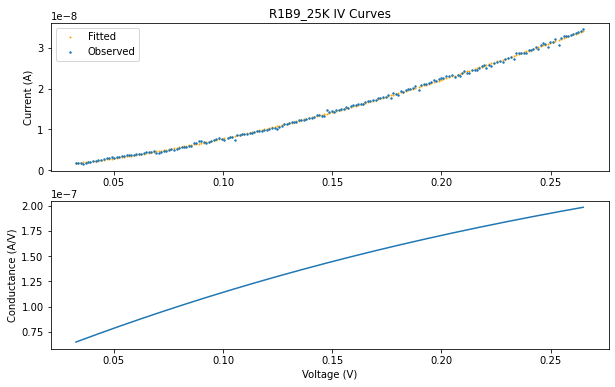

[ 2.02705422e-07 -4.24064339e-07  4.43968709e-07  3.72971789e-08
  4.99000000e-21]


C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: overflow encountered in exp
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)
C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: invalid value encountered in power
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


Conductance offset:  -9.738242728609882e-09
Current offset:  -4.869121364304941e-11
Temperature offset:  -3.263059980966883


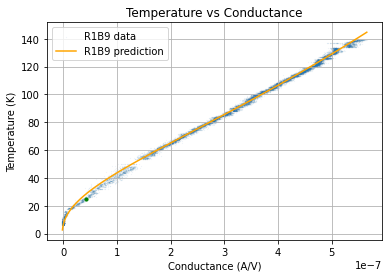

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9                 [5.70957012e+04 4.51468802e-01 9.08182910e+05]


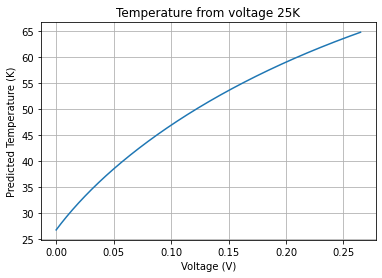

Prediction for 5mV: 28.263059980966883
Prediction for 0.2V: 59.05004419919305


C:\Users\sfska\PycharmProjects\Current Jumps\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


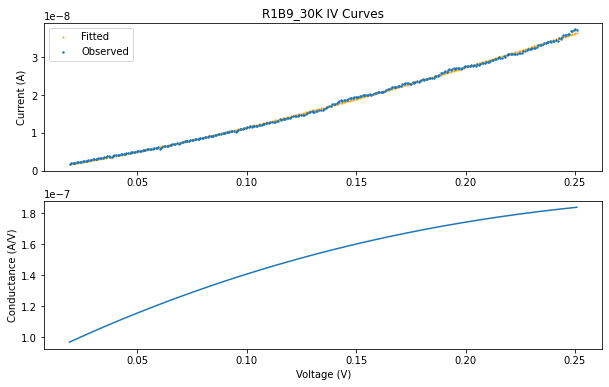

[ 1.87252694e-07 -4.61820864e-07  3.49413077e-07  8.38079147e-08
  4.99000000e-21]


C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: overflow encountered in exp
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)
C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: invalid value encountered in power
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


Conductance offset:  -8.726750248162012e-08
Current offset:  -4.363375124081006e-10
Temperature offset:  0.4923214992860885


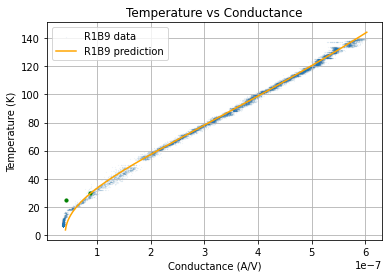

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9                 [7.11968554e+04 4.63851696e-01 8.42906708e+05]


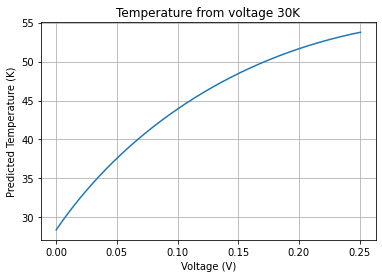

Prediction for 5mV: 29.50767850071391
Prediction for 0.2V: 51.64336786616893


C:\Users\sfska\PycharmProjects\Current Jumps\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


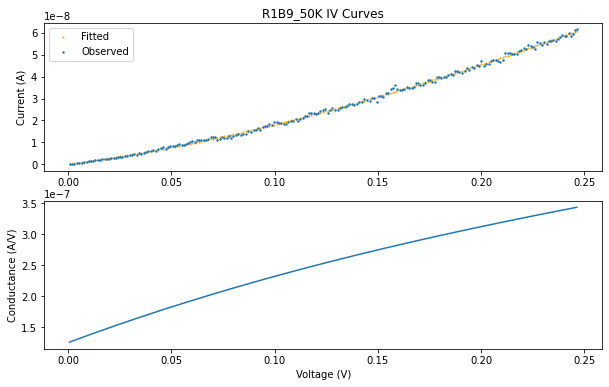

[ 4.55391801e-07 -6.25410359e-07  6.18325042e-07  1.25654845e-07
  4.99000000e-21]


C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: overflow encountered in exp
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)
C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: invalid value encountered in power
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


Conductance offset:  -4.775934548814366e-09
Current offset:  -2.3879672744071832e-11
Temperature offset:  -1.0450023241682942


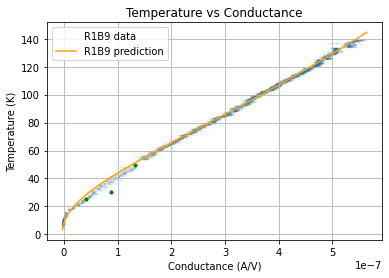

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9                 [6.15324856e+04 4.56185954e-01 8.94521041e+05]


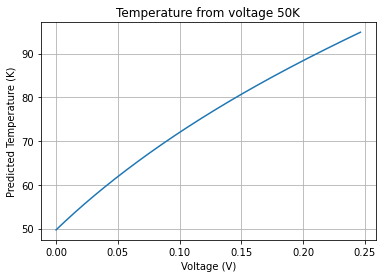

Prediction for 5mV: 51.045002324168294
Prediction for 0.2V: 88.3817862920949


C:\Users\sfska\PycharmProjects\Current Jumps\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


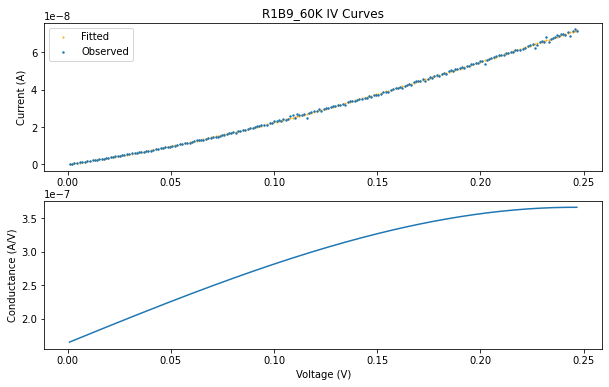

[-1.62046603e-06 -5.89781676e-08  6.29206808e-07  1.63765684e-07
  4.99000000e-21]


C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: overflow encountered in exp
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)
C:\Users\sfska\AppData\Local\Temp\ipykernel_49004\698592180.py:42: RuntimeWarning: invalid value encountered in power
  return  b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


Conductance offset:  -7.344826247145971e-09
Current offset:  -3.672413123572986e-11
Temperature offset:  -1.5573773756989127


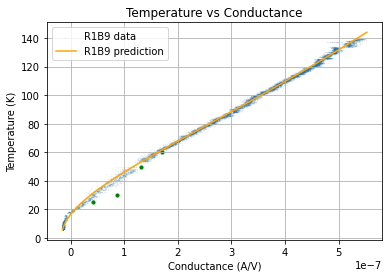

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9                 [1.19054088e+05 4.97901123e-01 7.76759124e+05]


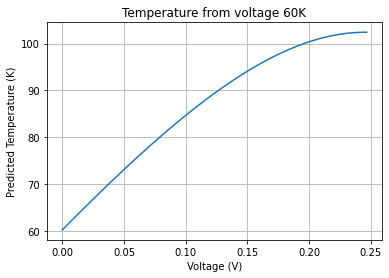

Prediction for 5mV: 61.55737737569891
Prediction for 0.2V: 100.36826385943743


In [4]:
### Cell to do all of the joule heating calculations ###


iv_curve_sheet = "R1B9_R2B8_IV_Curves_New.xlsx"

# precomputed current offsets for the raw data, can be recalculated by setting optimizing to True #
offsets = {
    "R1B9_25":-9.946217866012463e-12,
    "R1B9_30":2.0205788625411695e-10,
    "R1B9_50":-1.6712512714475806e-11,
    "R1B9_60":-8.611206284588801e-11,

    # average = 5.0515659271508186e-11
    "R2B8_25":5.697605056470524e-11,
    "R2B8_30":7.594748258805436e-11,
    "R2B8_50":5.396440825072287e-12,
    "R2B8_60":6.374266310820087e-11,
}

# filter out voltages above this for IV curve
cutoff = .3

# delete lowest points from the IV Curve if wanted
points_to_delete = 0

# filter out voltages below this
min_cutoff = None

# whether to optimize offsets
optimizing = False

# whether to show IV curves
plot_IVs = True

# whether to show conductance / temp plots (needed to actually compute them for later fitting
plot_RvsT = True

# temperatures to run simulation at, assumes corresponding subsheet in the key excel file
simulation_temps = [25,30,50,60]
fitted_functions = []
for simulation_temperature in simulation_temps:
    # key telling us where the RvsT data is and the subsheet (file, subsheet)
    key = ("R1B9_RvsT_5mV_New.xlsx", "Ithaca_all")
    key = key[0] + ":" + key[1]
    sheet_name = key
    short_name = sheet_name[:4]
    df = data_map[sheet_name].copy()

    # apply the current offset to the data
    current_offset = offsets[short_name+"_"+str(simulation_temperature)]
    df["Current"] += current_offset
    df["Conductance"] = df["Current"] / df["Voltage"]
    temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]


    sheet_name = short_name + ("_{}K".format(simulation_temperature))

    # read our IV curve
    voltages, currents =   plot_IV_curve_simple(sources_folder
                             + iv_curve_sheet
                             , sheet_name=sheet_name, silent=True,
                                voltage_lower_bound = min_cutoff,voltage_upper_bound=cutoff)
    voltages = voltages[points_to_delete:]
    currents = currents[points_to_delete:]

    # fit IV curve
    p, _ = curve_fit(IV_fit, voltages, currents,
                     bounds=[(-np.inf, -np.inf, -np.inf, -np.inf, -np.inf)
                         , (np.inf, np.inf, np.inf, np.inf, np.inf)],
                     p0=[0, 0, 0, 6.57e-07, 4.99e-21])



    outputs = np.polyval(p, voltages)
    derivs = np.polyder(p)
    deriv_outputs = np.polyval(derivs, voltages)

    if plot_IVs:
        fig, axs = plt.subplots(2, figsize=(10, 6))
        axs[0].set_title("{} IV Curves".format(sheet_name))
        axs[1].set_xlabel("Voltage (V)")
        axs[0].scatter(voltages, outputs, s=1, color='orange', label="Fitted")
        axs[0].scatter(voltages, currents, s=2, label="Observed")

        plt.grid()
        axs[0].legend()
        axs[0].set_ylabel("Current (A)")

        axs[1].plot(voltages,deriv_outputs)
        axs[1].set_ylabel("Conductance (A/V)")

        plt.savefig("../graphs/IV Curves and Conductance {} ".format(sheet_name).replace(".xlsx", "").replace(":", "") + str(simulation_temperature))

        plt.grid()
        plt.show()
        print(p)

    cond_to_temp, coeffs = fit_cond_to_temp(conductance, temp, -current_offset)

    if plot_RvsT:
        plt.figure()
        plt.grid()
        plt.scatter(conductance, temp, s=.0005, label="{} data".format(short_name))
        plt.xlabel("Conductance (A/V)")
        plt.ylabel("Temperature (K)")

        # calibration_conductance is the expected conductance for 5mV at 100K
        # since the two should fit at low voltage (Ohm heating regime)
        calibration_conductance = np.polyval(derivs, 5 / 1000)
        estimated_conductance = get_conductance(simulation_temperature, cond_to_temp)
        print("Conductance offset: ", estimated_conductance - calibration_conductance)
        print("Current offset: ", (estimated_conductance - calibration_conductance) * 5 / 1000)
        print("Temperature offset: ", simulation_temperature - cond_to_temp(calibration_conductance))

        if optimizing:
            offset, _ =  optimize_current_offset(calibration_conductance, key, offset = current_offset)
            print("Current offset to use: ", offset)
            # print("Voltage Offset to use: ", optimize_voltage_offset(calibration_conductance, key))


        # plot calibration point
        calibration_pairs[0].append(calibration_conductance)
        calibration_pairs[1].append(simulation_temperature)
        plt.scatter(calibration_pairs[0], calibration_pairs[1], s=10, color='green')
        domain = np.linspace(min(conductance), max(max(conductance), calibration_conductance), 1000)
        fitted_temps = [cond_to_temp(c) for c in domain]
        plt.plot(domain, fitted_temps, color='orange', label="{} prediction".format(short_name))
        plt.title("Temperature vs Conductance")
        plt.legend()

        plt.savefig("../graphs/Temperature vs Conductance {} ".format(sheet_name).replace(".xlsx", "").replace(":", "") + str(simulation_temperature))
        plt.show()
        plt.figure()
        print(" " * 44 + "np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)")
        print("Coefficients for {:<20}".format(short_name), coeffs)


    ### now try to compute temperature from a given voltage
    # plot voltages from 0 to 1
    domain = np.linspace(0, max(voltages), 50000)
    conductances = np.polyval(derivs, domain)
    temps = cond_to_temp(conductances)
    plt.plot(domain, temps)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Predicted Temperature (K)")
    plt.title("Temperature from voltage {}K".format(simulation_temperature))
    plt.grid()
    plt.savefig("../graphs/Predicted temperature from voltage {} ".format(short_name) + str(simulation_temperature))
    plt.show()

    print("Prediction for 5mV: {}".format(cond_to_temp(np.polyval(derivs, 5 / 1000))))
    print("Prediction for 0.2V: {}".format(cond_to_temp(np.polyval(derivs, 0.2))))
    fitted_functions.append((domain,temps,simulation_temperature))

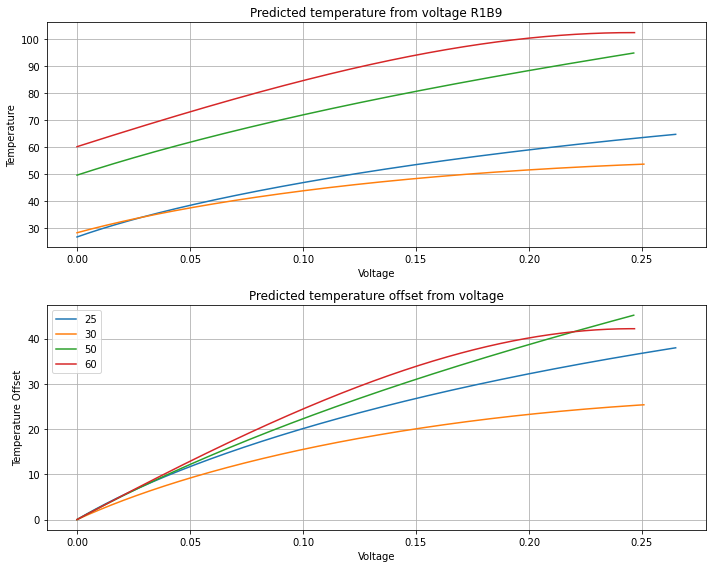

In [5]:
# plot predicted temperatures from voltages

fig, axs = plt.subplots(2,figsize=(10,8))

for domain, temps, name in fitted_functions:
    axs[0].plot(domain, temps, label = name)

axs[0].grid()
axs[0].set_title("Predicted temperature from voltage {}".format(short_name))
axs[0].set_xlabel("Voltage")
axs[0].set_ylabel("Temperature")


for domain, temps, name in fitted_functions:
    plt.plot(domain, np.array(temps)-temps[0], label = name)

axs[1].legend()
axs[1].grid()
axs[1].set_title("Predicted temperature offset from voltage")
axs[1].set_xlabel("Voltage")
axs[1].set_ylabel("Temperature Offset")
plt.tight_layout()
plt.savefig("../graphs/Comparing temperature offsets across temps")
plt.show()



In [9]:
# evaluate how much the joule heating corrections help #

mev_per_J = 6.242e21
lookup = {}
for domain, outs, name in fitted_functions:
    lookup[name] = (domain, outs)


# input information from the table
voltages = np.array([4.9,51,95,201])/1000
current_ratios = np.array([1.079,1.074,1.052,1.034])
given_temps = np.ones(len(voltages))*50

logged_ratios = np.log(2*current_ratios - 1)
given_energies = logged_ratios * k_b * given_temps * mev_per_J
predicted_temps = np.array([interp(x, lookup[50]) for x in voltages])
print(predicted_temps)
predicted_energies = predicted_temps * k_b * logged_ratios * mev_per_J
print("Spread of predictions:", np.std(predicted_energies))
print("Spread of originals:", np.std(given_energies))

diffs = predicted_energies-given_energies

# display summary of results
pd.DataFrame({"Shifted energies":predicted_energies, "Unshifted energies":given_energies, "Voltage": voltages, "Current Ratios": current_ratios, "energy shifts": diffs})

dict_keys([25, 30, 50, 60])
[51.01844537 62.09822522 71.04803029 88.52732243]
Spread of predictions: 0.08487211847757582
Spread of originals: 0.1394019056435412


,Shifted energies,Unshifted energies,Voltage,Current Ratios,energy shifts
0,0.644982,0.632107,0.0049,1.079,0.012875
1,0.738639,0.594735,0.0510,1.074,0.143905
2,0.605802,0.426333,0.0950,1.052,0.179469
3,0.501914,0.283480,0.2010,1.034,0.218434
